In [1]:
import numpy as np
import sklearn.linear_model as sklm
import matplotlib.pyplot as plt
import seaborn as sbn
sbn.set(font_scale=1.6)
%matplotlib inline

In [2]:
def calculate_sigma(truez,pz):
    ez = (truez-pz)/(1.+truez)
    return np.std(ez)

def calculate_IQR_sigma(truez,pz):
    ez = (truez-pz)/(1.+truez)
    x75,x25 = np.percentile(ez,[75.,25.])
    iqrsig = (x75-x25)/1.349
    return iqrsig

def calculate_bias(truez,pz):
    ez = (truez-pz)/(1.+truez)
    return np.median(ez)

In [3]:
infile = "sdssugrizsz.dat"
data = np.loadtxt(infile)
mags = data[:,:5]
truezs = data[:,5]

Plot r-mag vs redshift to see what the data looks like.  We see that it spans 10 < r < 19 and 0 < z < 0.6

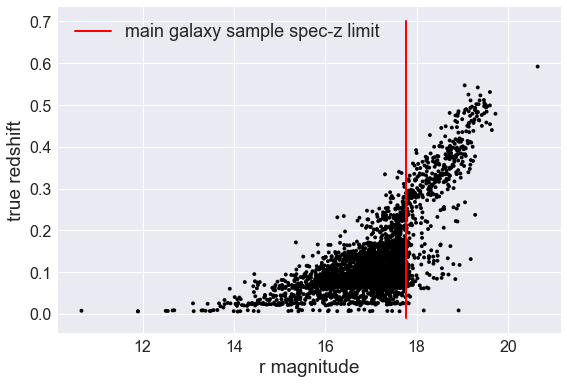

In [4]:
fig=plt.figure(figsize=(9,6))
plt.scatter(mags[:,2],truezs,marker='o',c='k',s=15,edgecolor='none')
plt.xlabel("r magnitude",fontsize=19)
plt.ylabel("true redshift",fontsize=19)
plt.plot([17.77,17.77],[-0.01,0.7],c='r',lw=2,label = "main galaxy sample spec-z limit")
plt.legend(loc='upper left',fontsize=18)

You can see the main galaxy sample cutoff at r=17.77, r>17.77 consists of LRG targets that extend to higher redshift. So, there is a strange extra-selection for the faint/high-redshift objects that may lead to a worse photo-z (watch for this later)

Next, make colors and plot them

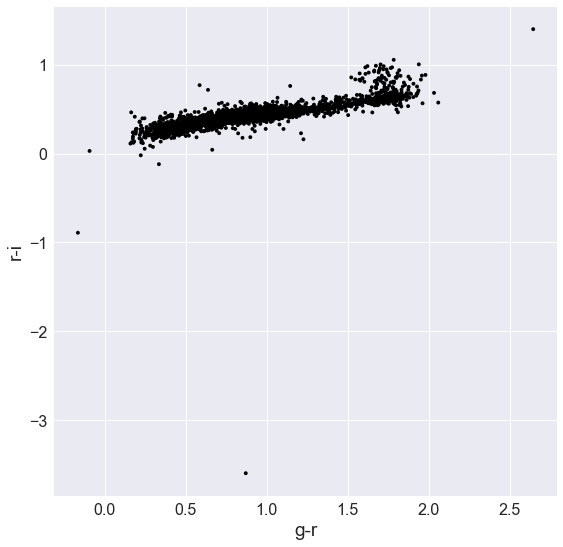

In [5]:
colors = mags[:,:-1] - mags[:,1:]
fig=plt.figure(figsize=(9,9))
plt.scatter(colors[:,1,],colors[:,2],marker='o',c='k',s=15,edgecolor='none')
plt.xlabel("g-r",fontsize=19)
plt.ylabel("r-i",fontsize=19)


A few outliers visible in the color-color diagram, zoom in on the main blob, a fairly tight locus, you can see the fainter LRGs start to bend to up in r-i color on the right side of the plot

(-0.4, 1.4)

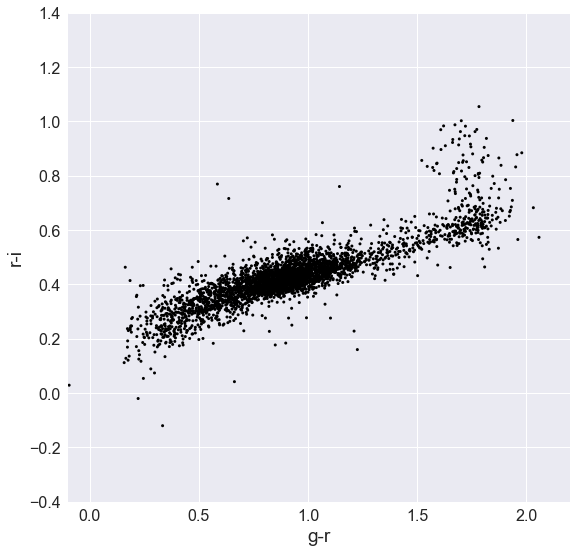

In [6]:
fig=plt.figure(figsize=(9,9))
plt.scatter(colors[:,1,],colors[:,2],marker='o',s=9,c='k',edgecolor='none')
plt.xlabel("g-r",fontsize=19)
plt.ylabel("r-i",fontsize=19)
plt.xlim([-0.1,2.2])
plt.ylim([-.4,1.4])

Now use the sklearn linear regression package to fit a simple linear model as a photo-z, of the form:
mag_photoz = const + A*u + B*g + C*r + D*i + E*z

In [7]:
linreg_mag = sklm.LinearRegression(fit_intercept=True,normalize=False)

In [8]:
linreg_mag.fit(mags,truezs)

/Users/sam/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Print the coefficients of the fit, then use predict to actually compute a photo-z for the galaxies (Note: we should have split the data into train and test, but this is just a quick example, so we'll do the improper thing and use the exact data that we used to create the fit)

In [9]:
print linreg_mag.intercept_
print linreg_mag.coef_

-0.676789004278
[-0.01375302  0.19648638 -0.08016321 -0.11470908  0.04999281]


In [10]:
mag_pzs = linreg_mag.predict(mags)

In [11]:
mag_sigma = calculate_IQR_sigma(truezs,mag_pzs)
print mag_sigma
mag_bias = calculate_bias(truezs,mag_pzs)
print mag_bias

0.0298221027721
-0.00350751034124


 The scatter is 0.0339, not too bad, for such a simple model!  Now, plot the linear regression photo-z, bias is fairly good as well.  Notice that the LRGs at the highest redshift are biased low, they had "weird" magnitudes/colors at the edge of the overall distribution.

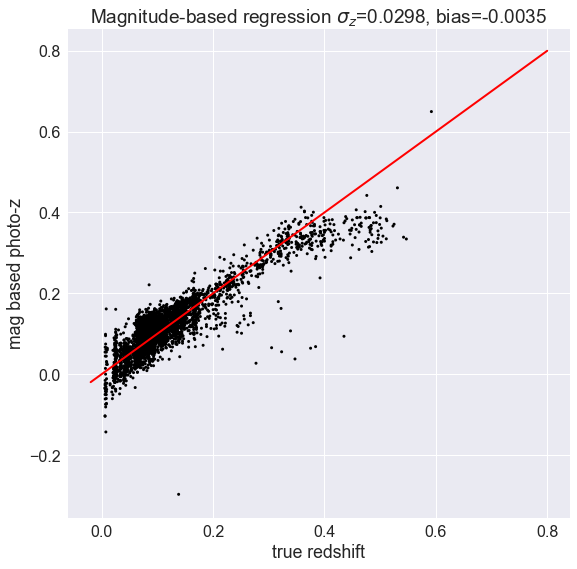

In [12]:
fig = plt.figure(figsize=(9,9))
plt.scatter(truezs,mag_pzs,marker='o',s=9,c='k',edgecolor='none')
plt.plot([-.02,.8],[-.02,0.8],c='r',lw=2)
plt.xlabel("true redshift")
plt.ylabel("mag based photo-z")
titletext = "Magnitude-based regression $\sigma_{z}$=%.4f, bias=%.4f"%(mag_sigma,mag_bias)
plt.title(titletext,fontsize=19)

Next, try linear regression using colors instead of magintudes

In [13]:
linreg_col = sklm.LinearRegression(fit_intercept=True,normalize=False)

In [14]:
linreg_col.fit(colors,truezs)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
print linreg_col.intercept_
print linreg_col.coef_

-0.0502740439083
[-0.02413899  0.25266435  0.05544313 -0.12575738]


In [16]:
col_pzs = linreg_col.predict(colors)
col_sigma = calculate_IQR_sigma(truezs,col_pzs)
print col_sigma

0.0330086536105


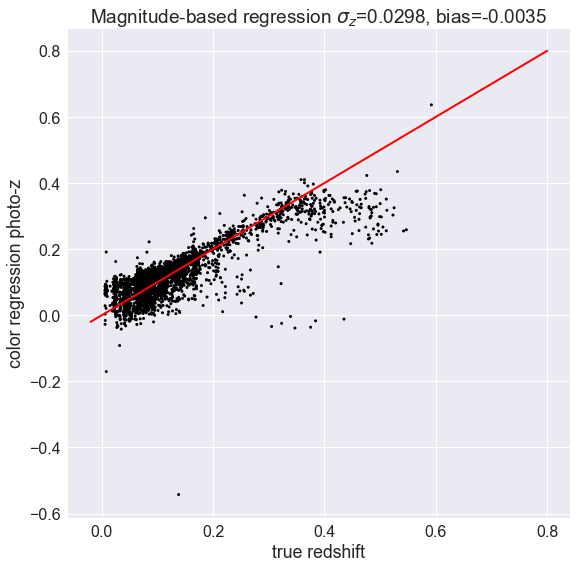

In [17]:
fig = plt.figure(figsize=(9,9))
plt.scatter(truezs,col_pzs,marker='o',s=9,c='k',edgecolor='none')
plt.plot([-.02,.8],[-.02,0.8],c='r',lw=2)
plt.xlabel("true redshift")
plt.ylabel("color regression photo-z")
titletext = "Magnitude-based regression $\sigma_{z}$=%.4f, bias=%.4f"%(mag_sigma,mag_bias)
plt.title(titletext,fontsize=19)

In this case, colors are actually slightly worse at predicting redshift than what we got using the magnitudes

# Read in fainter LSST mock data and see how the prediction does when extrapolating to fainter magnitudes

In [18]:
lsstfile = "lsstmags.dat"
lsstdata = np.loadtxt(lsstfile)
lsstmags = lsstdata[:,:5]
lssttruezs = lsstdata[:,5]
print (lssttruezs)

[ 0.112981  0.144592  0.184758 ...,  1.95861   0.477325  0.90991 ]


plot r-mag vs redshift, see that we now extend to z=2 and instead of ~10 < r < 18 for sdss, we now cover ~18 < r < 29

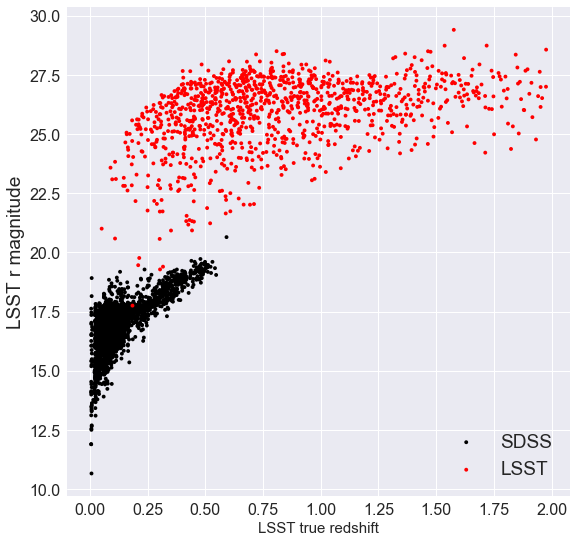

In [19]:
fig = plt.figure(figsize=(9,9))
plt.scatter(truezs,mags[:,2],marker='o',s=15,c='k',edgecolor='none',label='SDSS')
plt.scatter(lssttruezs,lsstmags[:,2],marker='o',c='r',s=15,edgecolor='none',label='LSST')
plt.xlabel("LSST true redshift",fontsize=15)
plt.ylabel("LSST r magnitude",fontsize=19)
plt.legend(loc='lower right',fontsize=19)

Almost no overlap, linear regression will be extrapolating quite a bit 

Create linear regression photo-z's for this sample that is not covered by the training data

In [20]:
lsst_mag_pzs = linreg_mag.predict(lsstmags)

In [21]:
lsst_mag_sigma = calculate_IQR_sigma(lssttruezs,lsst_mag_pzs)
print lsst_mag_sigma
lsst_mag_bias = calculate_bias(lssttruezs,lsst_mag_pzs)
print lsst_mag_bias

0.232211585179
0.160478835492


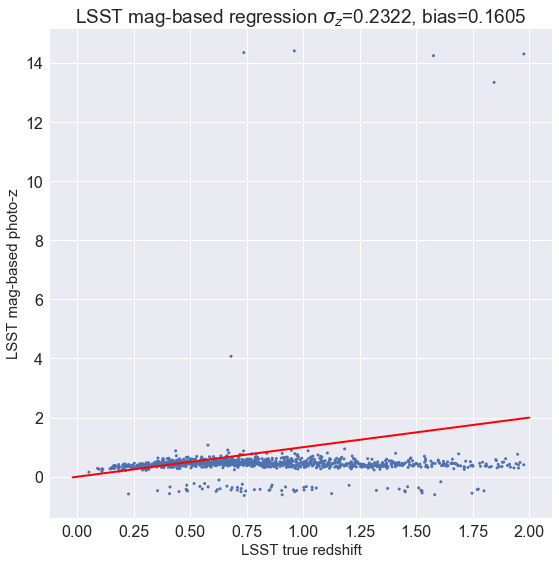

In [22]:
fig = plt.figure(figsize=(9,9))
plt.scatter(lssttruezs,lsst_mag_pzs,marker='o',s=9,edgecolor='none')
plt.plot([-.02,2.0],[-.02,2.0],c='r',lw=2)
plt.xlabel("LSST true redshift",fontsize=15)
plt.ylabel("LSST mag-based photo-z",fontsize=15)
titletext = "LSST mag-based regression $\sigma_{z}$=%.4f, bias=%.4f"%(lsst_mag_sigma,lsst_mag_bias)
plt.title(titletext,fontsize=19)

Bias is way worse (obviously).  There are several outliers due to non-detections with mag=99.0, zoom in on the main set of data points

(-1.0, 2.02)

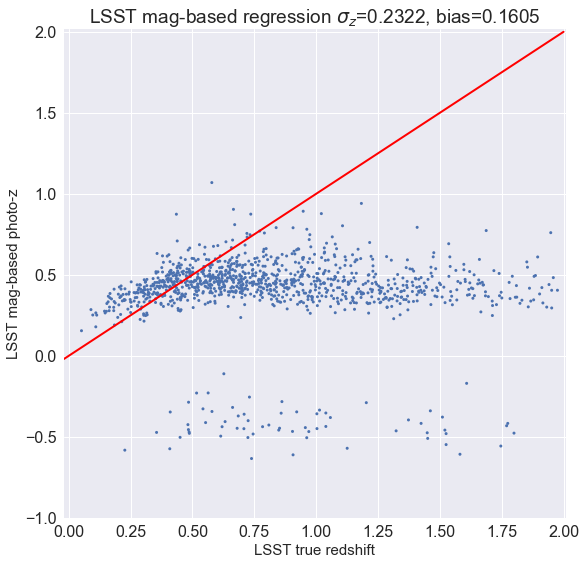

In [23]:
fig = plt.figure(figsize=(9,9))
plt.scatter(lssttruezs,lsst_mag_pzs,marker='o',s=9,edgecolor='none')
plt.plot([-.02,2.0],[-.02,2.0],c='r',lw=2)
plt.xlabel("LSST true redshift",fontsize=15)
plt.ylabel("LSST mag-based photo-z",fontsize=15)
titletext = "LSST mag-based regression $\sigma_{z}$=%.4f, bias=%.4f"%(lsst_mag_sigma,lsst_mag_bias)
plt.title(titletext,fontsize=19)
plt.xlim([-0.02,2.01])
plt.ylim([-1.,2.02])

In [24]:
lsstcolors = lsstmags[:,:-1] - lsstmags[:,1:]

Compare the LSST colors to the SDSS colors, at least for r-i vs g-r

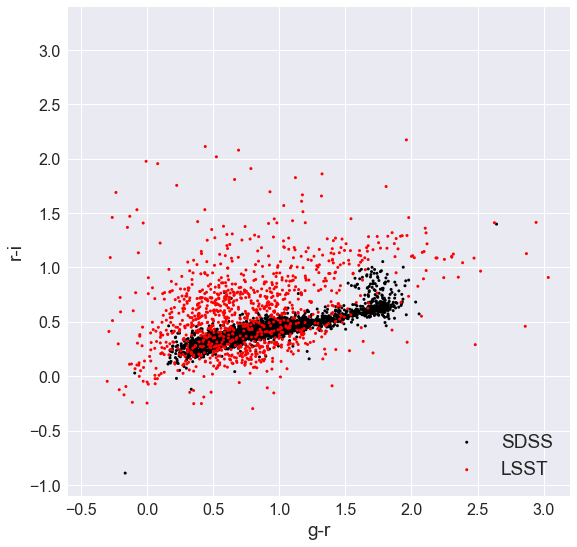

In [25]:
fit = plt.figure(figsize=(9,9))
plt.scatter(colors[:,1,],colors[:,2],marker='o',s=9,c='k',edgecolor='none',label = "SDSS")
plt.scatter(lsstcolors[:,1],lsstcolors[:,2],marker='o',c='r',s=9,edgecolor='none',label="LSST")
plt.xlabel("g-r",fontsize=19)
plt.ylabel("r-i",fontsize=19)
plt.xlim([-0.6,3.2])
plt.ylim([-1.1,3.4])
plt.legend(loc='lower right',fontsize=19)

Very different color distribution!  Don't expect very good photo-z's

In [26]:
lsst_col_pzs = linreg_col.predict(lsstcolors)
lsst_col_sigma = calculate_IQR_sigma(lssttruezs,lsst_col_pzs)
print lsst_col_sigma
lsst_col_bias = calculate_bias(lssttruezs,lsst_col_pzs)
print lsst_col_bias

0.22749431034
0.350068870507


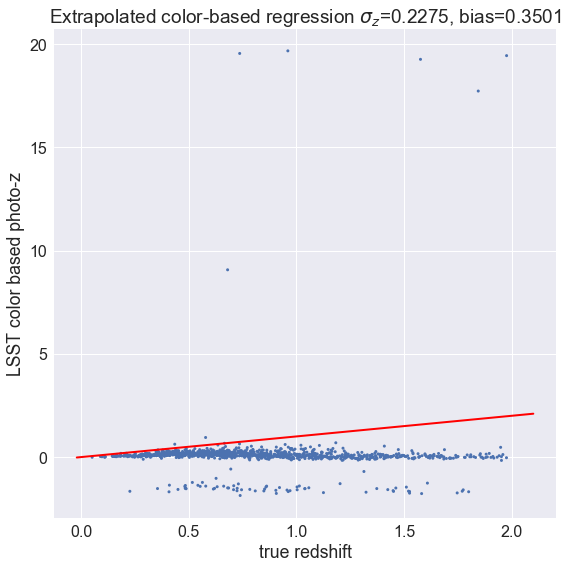

In [27]:
fig = plt.figure(figsize=(9,9))
plt.scatter(lssttruezs,lsst_col_pzs,marker='o',s=9,edgecolor='none')
plt.plot([-.02,2.1],[-.02,2.1],c='r',lw=2)
plt.xlabel("true redshift")
plt.ylabel("LSST color based photo-z")
titletext = "Extrapolated color-based regression $\sigma_{z}$=%.4f, bias=%.4f"%(lsst_col_sigma,lsst_col_bias)
plt.title(titletext,fontsize=19)

(-2, 2.5)

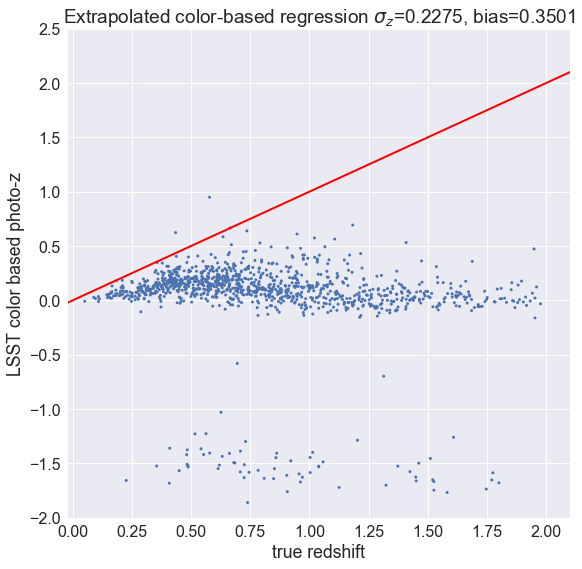

In [28]:
fig = plt.figure(figsize=(9,9))
plt.scatter(lssttruezs,lsst_col_pzs,marker='o',s=9,edgecolor='none')
plt.plot([-.02,2.1],[-.02,2.1],c='r',lw=2)
plt.xlabel("true redshift")
plt.ylabel("LSST color based photo-z")
titletext = "Extrapolated color-based regression $\sigma_{z}$=%.4f, bias=%.4f"%(lsst_col_sigma,lsst_col_bias)
plt.title(titletext,fontsize=19)
plt.xlim([-0.02,2.1])
plt.ylim([-2,2.5])